In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"
data = pd.read_csv(url)
data.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


In [6]:
data.isnull().sum()
data.fillna(data.median(), inplace=True)


In [7]:
categorical_features = ['furnishingstatus']
binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ], remainder='passthrough')


In [8]:
X = data.drop(columns=['price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0))])

lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso(alpha=0.1))])

elastic_net_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))])


In [10]:
ridge_pipeline.fit(X_train, y_train)
lasso_pipeline.fit(X_train, y_train)
elastic_net_pipeline.fit(X_train, y_train)


c:\Users\frogora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['furnishingstatus'])])),
                ('regressor', ElasticNet(alpha=0.1))])

In [11]:
ridge_mse = mean_squared_error(y_test, ridge_pipeline.predict(X_test))
lasso_mse = mean_squared_error(y_test, lasso_pipeline.predict(X_test))
elastic_net_mse = mean_squared_error(y_test, elastic_net_pipeline.predict(X_test))

print(f"Ridge MSE: {ridge_mse}")
print(f"Lasso MSE: {lasso_mse}")
print(f"Elastic Net MSE: {elastic_net_mse}")


Ridge MSE: 1759294868062.6338
Lasso MSE: 1754319161400.2563
Elastic Net MSE: 1841431009915.621


In [12]:
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_
lasso_coefs = lasso_pipeline.named_steps['regressor'].coef_
elastic_net_coefs = elastic_net_pipeline.named_steps['regressor'].coef_

print(f"Ridge non-zero coefficients: {np.sum(ridge_coefs != 0)}")
print(f"Lasso non-zero coefficients: {np.sum(lasso_coefs != 0)}")
print(f"Elastic Net non-zero coefficients: {np.sum(elastic_net_coefs != 0)}")


Ridge non-zero coefficients: 13
Lasso non-zero coefficients: 13
Elastic Net non-zero coefficients: 13


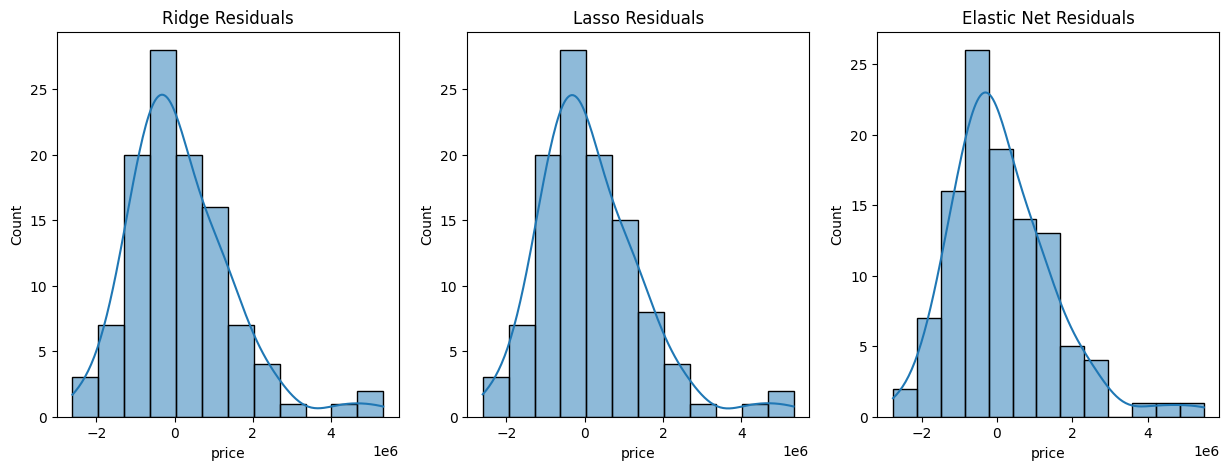

In [13]:
residuals_ridge = y_test - ridge_pipeline.predict(X_test)
residuals_lasso = y_test - lasso_pipeline.predict(X_test)
residuals_elastic_net = y_test - elastic_net_pipeline.predict(X_test)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(residuals_ridge, kde=True)
plt.title("Ridge Residuals")

plt.subplot(1, 3, 2)
sns.histplot(residuals_lasso, kde=True)
plt.title("Lasso Residuals")

plt.subplot(1, 3, 3)
sns.histplot(residuals_elastic_net, kde=True)
plt.title("Elastic Net Residuals")
plt.show()


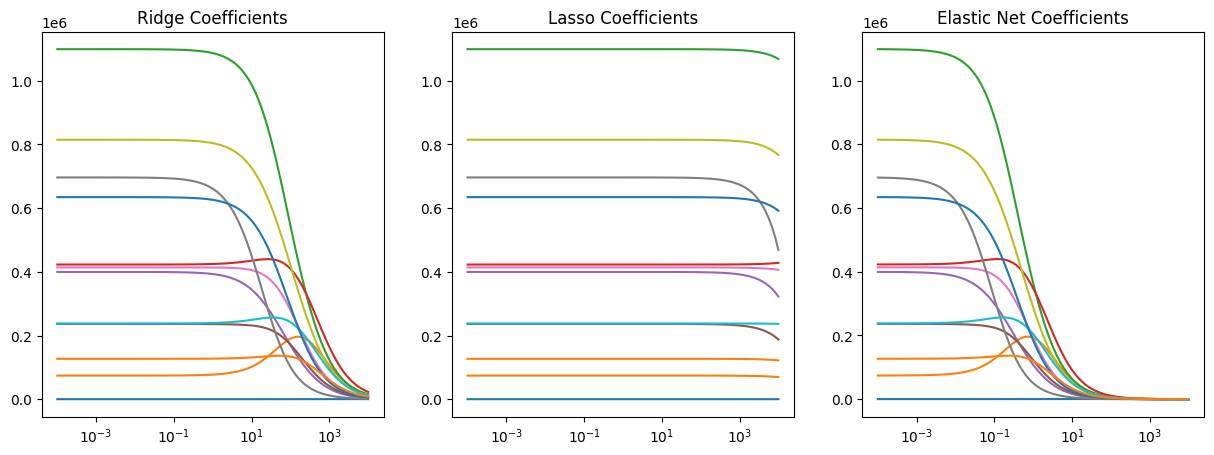

In [14]:
alphas = np.logspace(-4, 4, 100)
ridge_coefs = []
lasso_coefs = []
elastic_net_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)

    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    lasso_coefs.append(lasso.coef_)

    elastic_net = ElasticNet(alpha=alpha, l1_ratio=0.5).fit(X_train, y_train)
    elastic_net_coefs.append(elastic_net.coef_)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.title("Ridge Coefficients")

plt.subplot(1, 3, 2)
plt.plot(alphas, lasso_coefs)
plt.xscale('log')
plt.title("Lasso Coefficients")

plt.subplot(1, 3, 3)
plt.plot(alphas, elastic_net_coefs)
plt.xscale('log')
plt.title("Elastic Net Coefficients")
plt.show()
